In [ ]:
# Install Foolbox
!pip3 install -q foolbox

In [ ]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import eagerpy as ep

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Layer, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose, Reshape, Concatenate
from tensorflow.keras.losses import mean_squared_error, categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.callbacks import Callback
from tensorflow.random import uniform
from tensorflow import reduce_sum, convert_to_tensor, float32, int64, clip_by_value, boolean_mask, GradientTape

from foolbox.attacks import LinfProjectedGradientDescentAttack, LinfFastGradientAttack, LinfBasicIterativeAttack, L2BasicIterativeAttack, L2ProjectedGradientDescentAttack
from foolbox.models.base import Model as FModel
from foolbox import TensorFlowModel, accuracy, samples
from foolbox import attacks as fa

from eagerpy.tensor import TensorFlowTensor
from math import ceil
from random import randint
from typing import Callable

First we define hyperparameters, helper methods and classes:

In [ ]:
# @title HYPERPARAMETERS

# Dataset
dataset = 'cifar10'               #@param ["mnist", "fmnist", "cifar10"] {allow-input: false}

# Classifier hyperparameters
classifier_epochs = 250          #@param
classifier_batch_size = 128     #@param

# PuVAE hyperparameters
puvae_epochs = 350              #@param
puvae_batch_size = 512          #@param
puvae_latent_dim = 32           #@param
ce_koeff = 10                   #@param
rc_koeff = 0.01                 #@param
kl_koeff = 0.1                  #@param

# Detector hyperparameter
false_positives = 0.001         #@param 0.001 means that a maximum of 0.1% of clean examples gets classified as adversarial.

In [ ]:
# Load and preprocess data

def load_data(dataset=dataset):
    """ Loads and preprocesses data to be in range [0, 1].
    Args:
        dataset: 'mnist', 'fmnist', 'cifar10'
    Returns:
        (x_train, y_train), (x_test, y_test)
    """

    if dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    elif dataset == 'fmnist':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    if dataset == 'mnist' or dataset == 'fmnist':
        x_train = np.expand_dims(x_train, axis=-1)
        x_test = np.expand_dims(x_test, axis=-1)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Classifier architectures

class MNISTClassifier(Model):
    def __init__(self, **kwargs):
        super(MNISTClassifier, self).__init__(**kwargs)
        
        self.model = Sequential([
            Input(shape=(28,28,1)),
            Conv2D(64, (5,5), activation='relu'),
            Conv2D(64, (5,5), strides=(2,2), activation='relu'),
            Flatten(),
            Dropout(0.25),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(10)
        ])


    def call(self, inputs):
        return self.model(inputs)


class CIFAR10Classifier(Model):
    def __init__(self, **kwargs):
        super(CIFAR10Classifier, self).__init__(**kwargs)

        self.model = Sequential([
            Input(shape=(32,32,3)),
            Conv2D(64, (5,5), padding='same', activation='relu'),
            Conv2D(128, (5,5), padding='same', activation='relu'),
            Conv2D(256, (5,5), padding='same', activation='relu', dilation_rate=2),
            Flatten(),
            Dropout(0.25),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dense(10),
        ])

    def call(self, inputs):
        return self.model(inputs)

In [ ]:
# PuVAE architectures

class Sampling(Layer):
    def call(self, inputs, **kwargs):
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        sigma_epsilon = 0.1

        if 'training' in kwargs:
            training = kwargs.get("training")
            sigma_epsilon = 1.0 if training else 0.1

        epsilon = K.random_normal(shape=(batch, dim), stddev=sigma_epsilon)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

class Encoder(Layer):
    def __init__(self, latent_dim=32, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.conv1 = Conv2D(32, (7,7), dilation_rate=2, activation='relu', padding='same')
        self.conv2 = Conv2D(32, (7,7), dilation_rate=2, activation='relu', padding='same')
        self.conv3 = Conv2D(32, (7,7), dilation_rate=2, activation='relu', padding='same')

        self.dense1 = Dense(1024, activation='relu')
        self.dense2 = Dense(1024, activation='relu')

        self.dense3 = Dense(puvae_latent_dim, activation='relu', name='encoder_w_mean')
        self.dense4 = Dense(puvae_latent_dim, activation='softplus', name='encoder_w_var')

        self.sampling = Sampling()

    def call(self, inputs):
        x, y = inputs

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = Flatten()(x3)
        x5 = Concatenate()([x4, y])
        x6 = self.dense1(x5)
        x7 = self.dense2(x6)

        z_mean = self.dense3(x7)
        z_log_var = self.dense4(x7)
        z = self.sampling((z_mean, z_log_var))

        return z_mean, z_log_var, z

class Decoder(Layer):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense = Dense(512, activation='relu')
        self.deconv1 = Conv2DTranspose(32, (7,7), strides=2, padding='valid', activation='relu')
        self.deconv2 = Conv2DTranspose(32, (7,7), strides=2, padding='same', activation='relu')
        self.deconv3 = Conv2DTranspose(32, (7,7), strides=2, padding='same', activation='relu')
        self.deconv4 = Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid')

    def call(self, inputs):
        x, y = inputs

        x1 = Concatenate()([x, y])
        x2 = self.dense(x1)
        x3 = Reshape((1,1,512))(x2)
        x4 = self.deconv1(x3)
        x5 = self.deconv2(x4)
        x6 = self.deconv3(x5)
        x7 = self.deconv4(x6)

        return x7

class CIFAREncoder(Layer):
    def __init__(self, latent_dim=32, **kwargs):
        super(CIFAREncoder, self).__init__(**kwargs)

        self.conv1 = Conv2D(3, (2,2), padding='same', activation='relu')
        self.conv2 = Conv2D(32, (2,2), dilation_rate=2, padding='same', activation='relu')
        self.conv3 = Conv2D(32, (2,2), dilation_rate=2, padding='same', activation='relu')
        self.conv4 = Conv2D(32, (2,2), dilation_rate=2, padding='same', activation='relu')

        self.dense1 = Dense(1024, activation='relu')

        self.dense2 = Dense(puvae_latent_dim, activation='relu', name='encoder_w_mean')
        self.dense3 = Dense(puvae_latent_dim, activation='softplus', name='encoder_w_var')

        self.sampling = Sampling()

    def call(self, inputs):
        x, y = inputs

        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = Flatten()(x4)
        x6 = Concatenate()([x5, y])
        x7 = self.dense1(x6)

        z_mean = self.dense2(x7)
        z_log_var = self.dense3(x7)
        z = self.sampling((z_mean, z_log_var))

        return z_mean, z_log_var, z

class CIFARDecoder(Layer):
    def __init__(self, **kwargs):
        super(CIFARDecoder, self).__init__(**kwargs)
        self.dense1 = Dense(1024, activation='relu')
        self.dense2 = Dense(8192, activation='relu')
        self.deconv1 = Conv2DTranspose(32, (2,2), padding='same', activation='relu')
        self.deconv2 = Conv2DTranspose(32, (2,2), padding='same', activation='relu')
        self.deconv3 = Conv2DTranspose(32, (3,3), strides=2, padding='valid', activation='relu')
        self.conv1 = Conv2D(3, (2,2), activation='sigmoid')

    def call(self, inputs):
        x, y = inputs

        x1 = Concatenate()([x, y])
        x2 = self.dense1(x1)
        x3 = self.dense2(x2)
        x4 = Reshape((16,16,32))(x3)
        x5 = self.deconv1(x4)
        x6 = self.deconv2(x5)
        x7 = self.deconv3(x6)
        x8 = self.conv1(x7)

        return x8

class PuVAE(Model):
    def __init__(self, latent_dim=puvae_latent_dim, dataset='mnist', **kwargs):
        super(PuVAE, self).__init__(**kwargs)
        self.encoder = Encoder(latent_dim) if dataset == 'mnist' or dataset == 'fmnist' else CIFAREncoder(latent_dim)
        self.decoder = Decoder() if dataset == 'mnist' or dataset == 'fmnist' else CIFARDecoder()

    def call(self, inputs):
        x, y = inputs
        z_mean, z_log_var, z = self.encoder([x, y])
        reconstructions = self.decoder([z, y])
        return (z_mean, z_log_var, reconstructions)

In [ ]:
# Attacks

def categorical_crossentropy_with_logits(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, from_logits=True)

def sparse_categorical_crossentropy_with_logits(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

def custom_loss(y_true, y_pred):
    loss = K.mean(sparse_categorical_crossentropy_with_logits(y_true, y_pred))
    return loss

class CustomLossLinfPGDAttack(LinfProjectedGradientDescentAttack):
    def __init__(self, loss_fn, steps, rel_stepsize, random_start, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
        self.steps = steps
        self.rel_stepsize = rel_stepsize
        self.random_start = random_start

    def get_loss_fn(self, model: FModel, labels: ep.Tensor) -> Callable[[ep.Tensor], ep.Tensor]:
        """ Overwrites get_loss_fn of super class """
        def loss_fn(inputs: ep.Tensor) -> ep.Tensor:
            logits = model(inputs)
            loss = self.loss_fn(labels.raw, logits.raw)
            return TensorFlowTensor(reduce_sum(loss))
        return loss_fn

class CustomLossL2PGDAttack(L2ProjectedGradientDescentAttack):
    def __init__(self, loss_fn, steps, rel_stepsize, random_start, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
        self.steps = steps
        self.rel_stepsize = rel_stepsize
        self.random_start = random_start

    def get_loss_fn(self, model: FModel, labels: ep.Tensor) -> Callable[[ep.Tensor], ep.Tensor]:
        """ Overwrites get_loss_fn of super class """
        def loss_fn(inputs: ep.Tensor) -> ep.Tensor:
            logits = model(inputs)
            loss = self.loss_fn(labels.raw, logits.raw)
            return TensorFlowTensor(reduce_sum(loss))
        return loss_fn

class CustomLossLinfFGSMAttack(LinfFastGradientAttack):
    def __init__(self, loss_fn, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn

    def get_loss_fn(self, model: FModel, labels: ep.Tensor) -> Callable[[ep.Tensor], ep.Tensor]:
        """ Overwrites get_loss_fn of super class """
        def loss_fn(inputs: ep.Tensor) -> ep.Tensor:
            logits = model(inputs)
            loss = self.loss_fn(labels.raw, logits.raw)
            return TensorFlowTensor(reduce_sum(loss))
        return loss_fn


def base(attack, model, images, labels, batch_size, epsilons, bounds):
    # Preprocess test data to feed to Foolbox
    labels = np.argmax(labels, axis=1) # From categorical to raw labels
    images, labels = convert_to_tensor(images, dtype_hint=float32), convert_to_tensor(labels, dtype_hint=int64)
    fmodel = TensorFlowModel(model, bounds=bounds)

    outcomes = {}
    for eps in epsilons: outcomes[eps] = (0, 0)

    all_imgs, success_imgs, robustnesses, num_adversarial = [], [], [], []
    batch_size = batch_size if batch_size is not None else len(images)
    num_batches = ceil(len(images) / batch_size)

    for i in range(num_batches):
        last = i == num_batches - 1
        batch_images = images[i*batch_size:(i+1)*batch_size] if not last else images[i*batch_size:]
        batch_labels = labels[i*batch_size:(i+1)*batch_size] if not last else labels[i*batch_size:]

        _, imgs, successes = attack(fmodel, batch_images, batch_labels, epsilons=epsilons)
        successes = successes.numpy()

        num_attacks = len(batch_images)

        for j in range(len(epsilons)):
            success_idxs = successes[j] == 1

            try:
                all_imgs[j] = np.append(all_imgs[j], imgs[j], axis=0)
                success_imgs[j] = np.append(success_imgs[j], imgs[j][success_idxs], axis=0)
            except:
                all_imgs.append(imgs[j])
                success_imgs.append(imgs[j][success_idxs])

            eps = epsilons[j]
            num_successes = np.count_nonzero(success_idxs)
            outcome = (num_successes, num_attacks)
            outcome_so_far = outcomes[eps]
            outcomes[eps] = tuple(map(sum, zip(outcome, outcome_so_far)))

    for i, eps in enumerate(epsilons):
        num_successes, num_attacks = outcomes[eps]

        if len(success_imgs[i]) > 0:
            preds = np.argmax(model.predict(success_imgs[i]), axis=1)
            predicted_advs = np.count_nonzero(preds == 10)
            num_adversarial.append(predicted_advs)
            num_successes -= predicted_advs

        robustness = round(1.0 - num_successes / num_attacks, 3)
        robustnesses.append(robustness)

        print("For epsilon = {}, there were {}/{} successful attacks (robustness = {})".format(eps, num_successes, num_attacks, round(1.0 - num_successes / num_attacks, 3)))
    
    return all_imgs, success_imgs, robustnesses, num_adversarial

def pgd_attack(model, images, labels, norm="linf", loss_fn=sparse_categorical_crossentropy_with_logits, steps=40, rel_stepsize=0.01/0.3, random_start=True, batch_size=None, epsilons=[0.03, 0.1, 0.3], bounds=(0,1)):
    """ Evaluates robustness against an L-infinity PGD attack with random restart and 40 steps.
    Args:
        model: Tensorflow model to evaluate.
        images: Clean images that will be turned into adversarial examples.
        labels: Labels of the clean images.
        norm: 'L2' or 'Linf'.
        loss_fn: Specify loss function. Must take (y_true, y_pred) as parameters.
        steps: Number of iterations.
        rel_stepsize: How the value of alpha should be set relative to epsilon, i.e. alpha = rel_stepsize * epsilon.
        random_start: Boolean. If True, attack starts randomly within epsilon-ball. Set to False to run BIM attack.
        batch_size: Batch size.
        epsilons: Array of epsilon values for the attack.
        bounds: Pixel bounds of the model.

    Returns: 
        all_imgs: All the generated adversarial examples.
        success_imgs: Adversarial examples that successfully fooled the model.
        robustnesses: Array of robustness percentages for each epsilon.
        num_adversarial: Number of adversarial predictions for each epsilon.
    """

    print("Performing PGD attack...")
    if norm.lower() == "l2":
        attack = CustomLossL2PGDAttack(loss_fn, steps, rel_stepsize, random_start)
    if norm.lower() == "linf":
        attack = CustomLossLinfPGDAttack(loss_fn, steps, rel_stepsize, random_start)
    return base(attack, model, images, labels, batch_size, epsilons, bounds)


def fgsm_attack(model, images, labels, loss_fn=sparse_categorical_crossentropy_with_logits, batch_size=None, epsilons=[0.03, 0.1, 0.3], bounds=(0,1)):
    """ Evaluates robustness against an L-infinity FGSM attack without random restart.
    Args:
        model: Tensorflow model to evaluate.
        images: Clean images that will be turned into adversarial examples.
        labels: Labels of the clean images.
        loss_fn: Specify loss function. Must take (y_true, y_pred) as parameters.
        batch_size: Batch size.
        epsilons: Array of epsilon values for the attack.
        bounds: Pixel bounds of the model.

    Returns:
        all_imgs: All the generated adversarial examples.
        success_imgs: Adversarial examples that successfully fooled the model.
        robustnesses: Array of robustness percentages for each epsilon.
        num_adversarial: Number of adversarial predictions for each epsilon.
    """

    print("Performing FGSM attack...")
    attack = CustomLossLinfFGSMAttack(loss_fn)
    return base(attack, model, images, labels, batch_size, epsilons, bounds)

In [ ]:
# Custom layers

class BestReconstruction(Layer):
    def __init__(self, puvae, num_classes, **kwargs):
        self.puvae = puvae
        self.num_classes = num_classes
        self.eye = K.eye(num_classes)

        super(BestReconstruction, self).__init__(**kwargs)

    def call(self, inputs):
        batch_size = K.shape(inputs)[0]
        images = K.repeat_elements(inputs, self.num_classes, axis=0)
        labels = K.tile(self.eye, [batch_size, 1])

        _, _, reconstructions = self.puvae((images, labels))
        errors = K.mean(K.sqrt(mean_squared_error(images, reconstructions)), axis=(1,2))
        errors = K.reshape(errors, (batch_size, self.num_classes))

        best_idxs = K.argmin(errors) + K.arange(0, batch_size, dtype='int64') * self.num_classes
        best_reconstructions = K.gather(reconstructions, best_idxs)

        return best_reconstructions, K.min(errors, axis=1)


class Prediction(Layer):
    def __init__(self, threshold, **kwargs):
        self.t = threshold
        self.adv_one_hot = K.one_hot(10, 11)
        super(Prediction, self).__init__(**kwargs)

    def call(self, inputs):
        preds, errors = inputs
        batch_size = K.shape(preds)[0]
        
        # Vector of size batch_size with 1 in each index corresponding to a clean example, and 0 everywhere else
        keep_preds = K.expand_dims(K.cast(errors < self.t, 'float32'), axis=0)
        keep_preds = K.tile(keep_preds, [10, 1])
        keep_preds = K.transpose(keep_preds)

        adv_column = K.reshape(K.cast(errors >= self.t, 'float32'), (batch_size, 1))

        new_preds = preds * keep_preds
        new_preds = K.concatenate([new_preds, adv_column], axis=1)

        return new_preds

Then we use these to train and attack our model:

170500096/170498071 [==============================] - 6s 0us/step


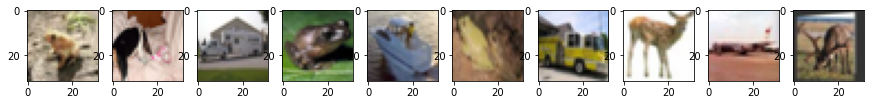

In [ ]:
# Load data and visualize
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = load_data()
elif dataset == 'fmnist':
    (x_train, y_train), (x_test, y_test) = load_data()
else:
    (x_train, y_train), (x_test, y_test) = load_data()

x_val, y_val = x_train[:6000], y_train[:6000]
x_train, y_train = x_train[6000:], y_train[6000:]

fig, ax = plt.subplots(1, 10, figsize=(15,14))
if dataset == 'mnist' or dataset == 'fmnist':
    for i in range(10): ax[i].imshow(x_train[i,:,:,0])
else:
    for i in range(10): ax[i].imshow(x_train[i,:,:,:])

In [ ]:
# Creates and trains the classifier which will be used in the training of PuVAE.
# The weights of the classifier are frozen after training.

if dataset == 'mnist' or dataset == 'fmnist':
    classifier = MNISTClassifier()
else:
    classifier = CIFAR10Classifier()

classifier.compile(optimizer='adam', loss=categorical_crossentropy_with_logits, metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=classifier_epochs, batch_size=128, shuffle=True)

for layer in classifier.layers: layer.trainable = False
classifier.compile(optimizer='adam', loss=categorical_crossentropy_with_logits, metrics=['accuracy'])
classifier.evaluate(x_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 1.4181 - accuracy: 0.4851


[1.4267797470092773, 0.48240000009536743]

In [ ]:
# Training the PuVAE. Since the weights of the classifier are frozen, only the PuVAE is trained.
# We do it this way since the loss function of PuVAE needs to include the cross-
# entropy loss of the classifier.

puvae = PuVAE(latent_dim=puvae_latent_dim, dataset=dataset, name='puvae')

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch%20 == 0:
            test_inputs = Input(shape=x_train[0].shape)
            test_reconstructions, _ = BestReconstruction(puvae, 10)(test_inputs)
            test_preds = classifier(test_reconstructions)
            test_model = Model(test_inputs, test_preds)

            x, y = self.test_data
            test_model.compile(metrics=['accuracy'])
            loss, acc = test_model.evaluate(x, y, verbose=0)
            print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

class PuVAEClassifier(Model):
    def __init__(self, puvae, classifier, **kwargs):
        super(PuVAEClassifier, self).__init__(**kwargs)
        self.puvae = puvae
        self.classifier = classifier
    
    def call(self, inputs):
        x, y = inputs
        z_mean, z_log_var, reconstructions = self.puvae(inputs)
        preds = self.classifier(reconstructions)

        kl_loss = K.square(z_mean) + K.exp(z_log_var) - K.log(K.exp(z_log_var) - 1)
        kl_loss = K.mean(kl_loss)
        rc_loss = K.mean(K.sum(binary_crossentropy(x, reconstructions), axis=(1,2)))
        ce_loss = categorical_crossentropy_with_logits(y, preds)

        self.add_loss(K.mean(ce_koeff*ce_loss + rc_koeff*rc_loss + kl_koeff*kl_loss))
        return preds

puvae_classifier = PuVAEClassifier(puvae, classifier)
puvae_classifier.compile(optimizer='adam', metrics=['accuracy'])
puvae_classifier.fit([x_train, y_train], y_train, epochs=puvae_epochs, batch_size=puvae_batch_size, shuffle=True, callbacks=[TestCallback((x_test, y_test))])

86/86 [==============================] - 27s 288ms/step - loss: 25.6810 - accuracy: 0.3668

Testing loss: 0.0, acc: 0.21250000596046448



In [ ]:
# Evaluate PuVAE accuracy on clean examples
inputs = Input(shape=x_train[0].shape)
best_reconstructions, errors = BestReconstruction(puvae, 10)(inputs)
preds = classifier(best_reconstructions)

model = Model(inputs, preds)
model.compile(metrics=['accuracy'])
model.summary()
model.evaluate(x_test, y_test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
best_reconstruction_1 (BestR ((None, 32, 32, 3), (None 42098830  
_________________________________________________________________
cifa_r10classifier (CIFAR10C (None, 10)                135381386 
Total params: 177,480,216
Trainable params: 42,098,830
Non-trainable params: 135,381,386
_________________________________________________________________
313/313 [==============================] - 8s 25ms/step - loss: 0.0000e+00 - accuracy: 0.2111


[0.0, 0.21209999918937683]

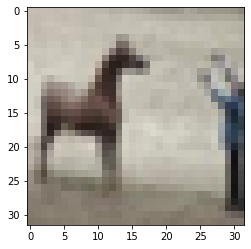

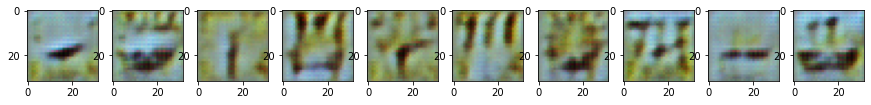

In [ ]:
# Picks a random image from the test set, and displays its 10 different
# reconstructions using the now trained PuVAE.

inputs_x = Input(shape=x_train[0].shape)
inputs_y = Input(shape=y_train[0].shape)
_, _, outputs = puvae((inputs_x, inputs_y))

model = Model([inputs_x, inputs_y], outputs)

rand_idx = randint(0, len(x_test))
img = x_test[rand_idx:rand_idx+1]
if dataset == 'mnist' or dataset == 'fmnist':
    plt.imshow(img[0,:,:,0])
else:
    plt.imshow(img[0,:,:,:])

img = np.repeat(img, 10, axis=0)
labels = np.eye(10, dtype='float32')
_, ax = plt.subplots(1, 10, figsize=(15,4))

for i in range(10):
    reconstruction = model.predict([img, labels])
    if dataset == 'mnist' or dataset == 'fmnist':
        ax[i].imshow(reconstruction[i,:,:,0])
    else:
        ax[i].imshow(reconstruction[i,:,:,:])

Predicted [8 8 1 1 0 6 8 9 5 4] for these images


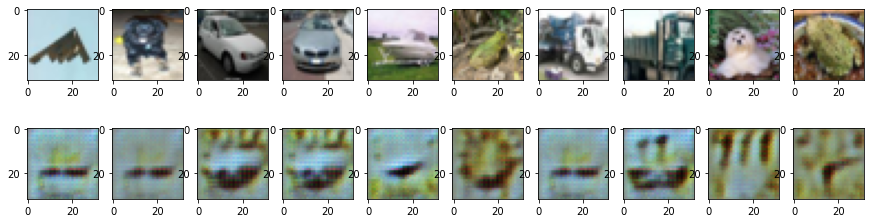

In [ ]:
# Showing the best reconstructions for a handful of different input images from
# the test set.

rand_idx = randint(0, len(x_test))
rand_img = x_test[rand_idx:rand_idx+10]
model = Model(inputs, best_reconstructions)
out_reconstructions = model.predict(rand_img)

print("Predicted {} for these images".format(np.argmax(classifier(out_reconstructions), axis=1)))

fig, ax = plt.subplots(2, 10, figsize=(15,4))
for i in range(10):
    if dataset == 'mnist' or dataset == 'fmnist':
        ax[0, i].imshow(rand_img[i,:,:,0])
        ax[1, i].imshow(out_reconstructions[i,:,:,0])
    else:
        ax[0, i].imshow(rand_img[i,:,:,:])
        ax[1, i].imshow(out_reconstructions[i,:,:,:])

In [ ]:
# Evaluate robustness WITHOUT detector using epsilon=0.3. In order to avoid
# running out of memory, batch size shouldn't exceed 250.

model = Model(inputs, preds)
model.compile(metrics=['accuracy'])
model.evaluate(x_test, y_test)

epsilons = [0.3] if dataset == 'mnist' or dataset == 'fmnist' else [0.06]

_ = fgsm_attack(model, x_test, y_test, loss_fn=custom_loss, epsilons=epsilons, batch_size=250)
_ = pgd_attack(model, x_test, y_test, loss_fn=custom_loss, epsilons=epsilons, batch_size=250, random_start=False) # PGD without random restart is BIM
_ = pgd_attack(model, x_test, y_test, loss_fn=custom_loss, epsilons=epsilons, batch_size=250, random_start=True)

313/313 [==============================] - 8s 25ms/step - loss: 0.0000e+00 - accuracy: 0.2109
Performing FGSM attack...
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
For epsilon = 0.06, there were 7966/10000 successful attacks (robustness = 0.203)
Performing PGD attack...
For epsilon = 0.06, there were 7914/10000 successful attacks (robustness = 0.209)
Performing PGD attack...
For epsilon = 0.06, there were 7905/10000 successful attacks (robustness = 0.21)


In [ ]:
# Select threshold for the detector

ts = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25]
t = None
for tt in ts:
    predictions = Prediction(threshold=tt)([preds, errors])

    detector_model = Model(inputs, predictions)
    benchmark_preds = np.argmax(detector_model.predict(x_val), axis=1)
    adv_count = np.count_nonzero(benchmark_preds == 10)
    print("Number of adversarial predictions for t={}: {}".format(tt, adv_count))
    if adv_count <= len(x_val) * false_positives:
        t = tt
        break
print("Selected t="+str(t))

Number of adversarial predictions for t=0.05: 6000
Number of adversarial predictions for t=0.06: 6000
Number of adversarial predictions for t=0.07: 6000
Number of adversarial predictions for t=0.08: 6000
Number of adversarial predictions for t=0.09: 6000
Number of adversarial predictions for t=0.1: 5996
Number of adversarial predictions for t=0.11: 5982
Number of adversarial predictions for t=0.12: 5953
Number of adversarial predictions for t=0.13: 5873
Number of adversarial predictions for t=0.14: 5742
Number of adversarial predictions for t=0.15: 5554
Number of adversarial predictions for t=0.16: 5267
Number of adversarial predictions for t=0.17: 4963
Number of adversarial predictions for t=0.18: 4558
Number of adversarial predictions for t=0.19: 4128
Number of adversarial predictions for t=0.2: 3640
Number of adversarial predictions for t=0.21: 3145
Number of adversarial predictions for t=0.22: 2642
Number of adversarial predictions for t=0.23: 2190
Number of adversarial predictions

In [ ]:
# Evaluate robustness WITH detector using epsilon=0.3. In order to avoid running
# out of memory, batch size shouldn't exceed 250.

y_test_clean = np.concatenate((y_test, np.zeros((len(y_test),1))), axis=1)

detector_model.compile(metrics=['accuracy'])
detector_model.evaluate(x_test, y_test_clean)

_ = fgsm_attack(detector_model, x_test, y_test, loss_fn=custom_loss, epsilons=epsilons, batch_size=250)
_ = pgd_attack(detector_model, x_test, y_test, loss_fn=custom_loss, epsilons=epsilons, batch_size=250, random_start=False)
_ = pgd_attack(detector_model, x_test, y_test, loss_fn=custom_loss, epsilons=epsilons, batch_size=250, random_start=True)

313/313 [==============================] - 8s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1736
Performing FGSM attack...
For epsilon = 0.06, there were 5963/10000 successful attacks (robustness = 0.404)
Performing PGD attack...
For epsilon = 0.06, there were 5965/10000 successful attacks (robustness = 0.403)
Performing PGD attack...
For epsilon = 0.06, there were 5955/10000 successful attacks (robustness = 0.404)
